# Develop adjoint LBVP - example

## Option 1: Avoid convert

In [1]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np

from dedalus.tools import jacobi
from dedalus.core import operators
from scipy import optimize

logger = logging.getLogger(__name__)

In [2]:
# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = -1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)

# # Forcing
fu = dist.Field(name='fu',bases=(ybasis2))
fv = dist.Field(name='fv',bases=(ybasis2))
fw = dist.Field(name='fw',bases=(ybasis2))

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 1000
omega = dist.Field(name='omega')
omega['g'] = 0.278
# # Problem
problem = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu")
problem.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv")
problem.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

In [3]:
# Solver
solver = problem.build_solver()

In [4]:
# Get spectrally accurate weight matrices
a, b = ybasis.a, ybasis.b
integ_vector = jacobi.integration_vector(Ny, a, b)

a2, b2 = ybasis2.a, ybasis2.b
integ_vector2 = jacobi.integration_vector(Ny, a2, b2)

W_field = u.copy_adjoint()
W_field2 = fu.copy_adjoint()
for i in range(Ny):
    W_field['c'][i] = integ_vector[i]
    W_field2['c'][i] = integ_vector2[i]
    
# Check integration
u.fill_random()
b = (np.conj(u)*u).evaluate()['c']
print(d3.integ(np.conj(u)*u).evaluate()['g'][0])
print(np.sum(W_field['c']*b))

(162.9656783717454+0j)
(162.9656783717455+0j)


In [5]:
def directAdjointLoopGrid(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    fu['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.vdot(W_field2['c'],(np.conj(fu)*fu+np.conj(fv)*fv+np.conj(fw)*fw).evaluate()['c'])
    
    solver.solve()

    # Check
    cost = np.vdot(W_field['c'],(np.conj(u)*u+np.conj(v)*v+np.conj(w)*w).evaluate()['c'])
    cost = cost/forcNorm
        
    solver.state_adj[0]['g'] = W_field['g']*u['g']/forcNorm
    solver.state_adj[1]['g'] = W_field['g']*v['g']/forcNorm
    solver.state_adj[2]['g'] = W_field['g']*w['g']/forcNorm
    
    solver.solve_adjoint()
    
    gradu['g'] = -cost/forcNorm*W_field2['g']*fu['g']  + solver.F_adj[0]['g']
    gradv['g'] = -cost/forcNorm*W_field2['g']*fv['g']  + solver.F_adj[1]['g']
    gradw['g'] = -cost/forcNorm*W_field2['g']*fw['g']  + solver.F_adj[2]['g']

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [6]:
opts = {'disp': True}
forcing = np.random.rand(Ny*2*3)

sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True,options=opts)

2023-03-07 16:25:27,985 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+00/s
2023-03-07 16:25:28,048 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10428D+01    |proj g|=  1.13092D+00

At iterate    1    f= -7.82591D+02    |proj g|=  9.97962D-01

At iterate    2    f= -8.58401D+02    |proj g|=  2.79038D-01

At iterate    3    f= -8.93425D+02    |proj g|=  1.27336D-01

At iterate    4    f= -9.06127D+02    |proj g|=  5.21636D-02

At iterate    5    f= -9.07169D+02    |proj g|=  2.64793D-02

At iterate    6    f= -9.07533D+02    |proj g|=  1.46597D-02

At iterate    7    f= -9.07628D+02    |proj g|=  7.92197D-03

At iterate    8    f= -9.07657D+02    |proj g|=  5.04510D-03

At iterate

 This problem is unconstrained.
/Users/calumskene/opt/miniconda3/envs/dedalus-adj/lib/python3.10/site-packages/scipy/optimize/_lbfgsb_py.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


Text(0.5, 1.0, 'Optimal response')

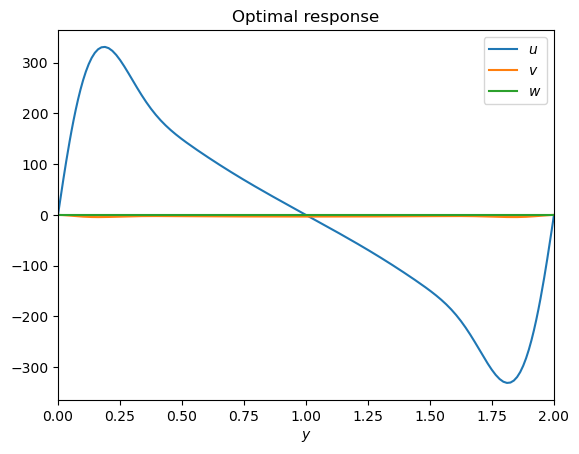

In [7]:
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal response')

Text(0.5, 1.0, 'Optimal forcing')

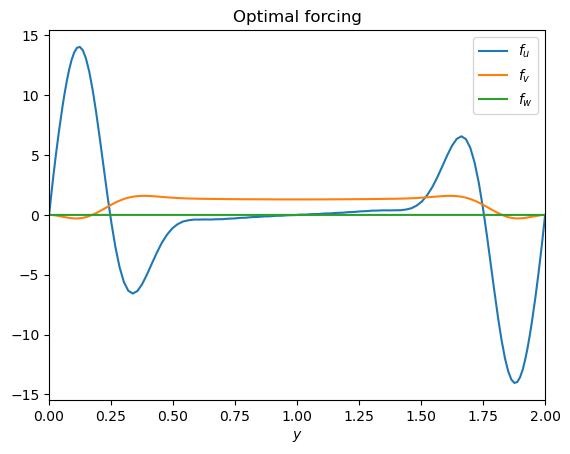

In [8]:
plt.plot(y,fu['g'].real,label=r'$f_u$')
plt.plot(y,fv['g'].real,label=r'$f_v$')
plt.plot(y,fw['g'].real,label=r'$f_w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal forcing')

In [9]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver = problem.build_solver()
    sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True)
    gains.append(sol.fun)
gains = -np.array(gains)

2023-03-07 16:25:28,984 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-03-07 16:25:29,028 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:29,249 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-07 16:25:29,296 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-07 16:25:29,493 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 16:25:29,539 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:29,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:29,793 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 16:25:37,277 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:37,482 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 16:25:37,530 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-07 16:25:37,751 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:25:37,795 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:37,997 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 16:25:38,040 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 16:25:38,346 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 16:25:45,386 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-03-07 16:25:45,435 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-03-07 16:25:45,644 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:25:45,687 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:25:45,961 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
2023-03-07 16:25:46,014 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-03-07 16:25:46,329 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
2023-03-07 16:25:46,388 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 16:25:53,695 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:25:53,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 16:25:53,911 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:25:54,083 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:25:54,126 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:25:54,303 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:25:54,346 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:25:54,510 subsystems 0/1 INFO :: Building subproblem matrices 

/Users/calumskene/opt/miniconda3/envs/dedalus-adj/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.1, 1.5)

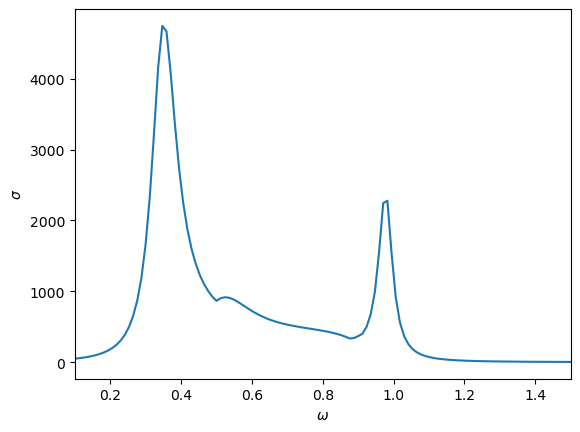

In [10]:
plt.plot(omegas,gains)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.xlim([omegas[0],omegas[-1]])

## Option 2: with adjoint convert

In [11]:
# Forcing
fu2 = dist.Field(name='fu',bases=(ybasis))
fv2 = dist.Field(name='fv',bases=(ybasis))
fw2 = dist.Field(name='fw',bases=(ybasis))

# # Problem
problem2 = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem2.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu2")
problem2.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv2")
problem2.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw2")
problem2.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem2.add_equation("u(y=0) = 0")
problem2.add_equation("u(y=2) = 0")

problem2.add_equation("v(y=0) = 0")
problem2.add_equation("v(y=2) = 0")

problem2.add_equation("w(y=0) = 0")
problem2.add_equation("w(y=2) = 0")

In [12]:
# Solver
solver2 = problem2.build_solver()
# Check fu2 has the different bases so adjoint connvert needed
print(fu2.domain.bases[0])
print(solver2.F[0].domain.bases[0])

Jacobi(y, 128, a0=-0.5, b0=-0.5, a=-0.5, b=-0.5, dealias=1)
Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)


In [13]:
def directAdjointLoopGridConvert(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    
    fu2['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv2['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw2['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.vdot(W_field['c'],(np.conj(fu2)*fu2+np.conj(fv2)*fv2+np.conj(fw2)*fw2).evaluate()['c'])

    solver2.solve()

    cost = np.vdot(W_field['c'],(np.conj(u)*u+np.conj(v)*v+np.conj(w)*w).evaluate()['c'])
    cost = cost/forcNorm
    
    solver2.state_adj[0]['g'] = W_field['g']*u['g']/forcNorm
    solver2.state_adj[1]['g'] = W_field['g']*v['g']/forcNorm
    solver2.state_adj[2]['g'] = W_field['g']*w['g']/forcNorm
        
    solver2.solve_adjoint()
    
    # Now needed to adjoint convert!!! #
    # solver.F_adj is in adjoint second derivative basis
    # so after convert need a adjoint no derivative basis like state_adj
    F_adj0 = solver2.state_adj[0].copy()
    F_adj1 = solver2.state_adj[1].copy()
    F_adj2 = solver2.state_adj[2].copy()
    
    # Uncomment next three lines to check that convert works using adjoint bases of solver.F_adj
#     solver.F_adj[0]['g']
#     solver.F_adj[1]['g']
#     solver.F_adj[2]['g']
    
    convert = operators.convert(fu2, (ybasis2,))
    convert.operate_adjoint(solver2.F_adj[0],F_adj0)
    convert.operate_adjoint(solver2.F_adj[1],F_adj1)
    convert.operate_adjoint(solver2.F_adj[2],F_adj2)
    ####################################
    
    gradu['g'] = -cost/forcNorm*W_field['g']*fu2['g']  + F_adj0['g']
    gradv['g'] = -cost/forcNorm*W_field['g']*fv2['g']  + F_adj1['g']
    gradw['g'] = -cost/forcNorm*W_field['g']*fw2['g']  + F_adj2['g']

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [14]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains2 = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver2 = problem2.build_solver()
    sol = optimize.minimize(directAdjointLoopGridConvert,forcing,method='L-BFGS-B',jac=True)
    gains2.append(sol.fun)
gains2 = -np.array(gains2)

2023-03-07 16:25:58,841 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:58,883 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:25:59,069 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 16:25:59,114 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:59,295 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 16:25:59,340 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:25:59,522 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 16:25:59,569 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 16:26:05,960 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 16:26:06,158 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 16:26:06,200 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:26:06,397 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:26:06,440 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 16:26:06,633 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 16:26:06,676 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:26:06,940 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 16:26:13,622 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 16:26:13,665 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 16:26:13,956 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 16:26:13,998 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:26:14,224 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:26:14,268 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:26:14,500 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:26:14,543 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 16:26:21,452 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-07 16:26:21,657 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:26:21,703 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-07 16:26:21,865 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 16:26:21,910 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 16:26:22,091 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-03-07 16:26:22,164 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s
2023-03-07 16:26:22,436 subsystems 0/1 INFO :: Building subproblem matrices 

(0.1, 1.5)

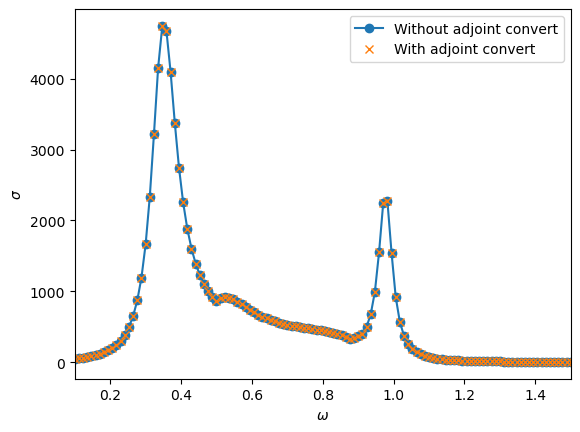

In [15]:
# Check same results as those with convert
plt.plot(omegas,gains,'-o',label=r'Without adjoint convert')
plt.plot(omegas,gains2,'x',label=r'With adjoint convert')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.xlim([omegas[0],omegas[-1]])